In [1]:
import pandas as pd
import os
from glob import glob

pasta = "Resultados2\Results"

arquivos = glob(os.path.join(pasta, "*.csv"))

def parse_nome(nome):
    base = os.path.basename(nome).replace(".csv", "")
    partes = base.split("_")

    representacao = partes[0]
    sampling = partes[-1]
    modelo = "_".join(partes[1:-1])

    return representacao, modelo, sampling

dfs = []

for arq in arquivos:
    rep, modelo, sampling = parse_nome(arq)
    
    df = pd.read_csv(arq)
    
    # adiciona colunas
    df["representacao"] = rep
    df["modelo"] = modelo
    df["sampling"] = sampling
    
    # coloca essas três colunas no começo
    novas_cols = ["representacao", "modelo", "sampling"]
    df = df[novas_cols + [c for c in df.columns if c not in novas_cols]]
    
    dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)

In [2]:
df_final

,representacao,modelo,sampling,Model,Accuracy_mean,Accuracy_std,BalAcc_mean,BalAcc_std,F1_mean,F1_std,...,Precision_mean,Precision_std,Recall_mean,Recall_std,FitTime_mean,FitTime_std,ScoreTime_mean,ScoreTime_std,Balanced_mean,ROC_mean
0,DESC,,original,LightGBM,0.804306,0.025958,0.783372,0.030348,0.730602,0.040430,...,0.775583,0.038977,0.692670,0.057440,4.779615,0.066398,0.015568,0.002480,NaN,NaN
1,DESC,,original,CatBoost,0.806220,0.019304,0.781964,0.021114,0.728532,0.028365,...,0.790380,0.033849,0.676651,0.036164,12.576280,2.576635,0.013921,0.001952,NaN,NaN
2,DESC,,original,XGBoost,0.801914,0.027826,0.780547,0.029565,0.727456,0.038682,...,0.773344,0.044519,0.687809,0.043874,4.432126,0.066612,0.014241,0.003519,NaN,NaN
3,DESC,,original,HistGradientBoosting,0.797129,0.022690,0.776666,0.024669,0.722613,0.032433,...,0.762635,0.036303,0.687840,0.041949,0.982723,0.016619,0.012465,0.004133,NaN,NaN
4,DESC,,original,RandomForest,0.803828,0.024605,0.774204,0.028174,0.716269,0.039513,...,0.806543,0.039677,0.645586,0.049575,1.261641,0.445866,0.447061,0.422484,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,Embedding,PMBert,under,Bagging,0.639713,0.033610,0.615784,0.041167,0.520695,0.066165,...,0.532676,0.086838,0.512360,0.059419,4.909921,0.051702,0.038845,0.002178,NaN,NaN
821,Embedding,PMBert,under,DecisionTree,0.579426,0.027849,0.580752,0.025890,0.515429,0.035405,...,0.463794,0.048320,0.584093,0.039455,1.105937,0.098894,0.011475,0.003753,NaN,NaN
822,Embedding,PMBert,under,QDA,0.511483,0.042043,0.541036,0.022264,0.509025,0.045859,...,0.418819,0.052160,0.668527,0.117941,0.395214,0.014557,0.026870,0.003179,NaN,NaN
823,Embedding,PMBert,under,BernoulliNB,0.554067,0.035218,0.542674,0.036701,0.461084,0.058121,...,0.430250,0.065926,0.498079,0.050026,0.064895,0.004176,0.018103,0.001745,NaN,NaN


In [7]:
df_final['representacao'].unique()

array(['DESC', 'DEST', 'EMBDESC', 'EMBDEST', 'Embedding'], dtype=object)

In [34]:
# Colunas de interesse
metrics = ["F1"]

representacao_desejados = [
    "Embedding",
]

# 1. Filtrar usando coluna 'modelo' (minúsculo!)
df_mlp_orig = (
    df_final[
        (df_final["representacao"].isin(representacao_desejados)) &
        (df_final["sampling"] == "original")
    ]
    .sort_values(by="F1_mean", ascending=False)
    .copy()
)

print("Linhas após filtro:", len(df_mlp_orig))

# 2. Criar coluna F1 como "mean ± std"
df_mlp_orig["F1"] = (
    df_mlp_orig["F1_mean"].round(3).astype(str)
    + " ± "
    + df_mlp_orig["F1_std"].round(3).astype(str)
)

# 3. Criar coluna representacao_modelo = representacao + modelo
df_mlp_orig["representacao_modelo"] = (
    df_mlp_orig["representacao"] + " – " + df_mlp_orig["modelo"]
)

# 4. Selecionar colunas corretas
df_mlp_orig = df_mlp_orig[["Model", "representacao_modelo", "F1"]]

# 5. Remover duplicados, se existirem
df_mlp_orig = df_mlp_orig.drop_duplicates(subset=["Model", "representacao_modelo"])

# 6. Pivotar: linhas = Model, colunas = representacao_modelo
df_Embedings_original = df_mlp_orig.pivot(
    index="Model",
    columns="representacao_modelo",
    values="F1"
).reset_index()

df_Embedings_original = df_Embedings_original[
    df_Embedings_original["Model"] != "QDA"
]

df_Embedings_original

Linhas após filtro: 175


representacao_modelo,Model,Embedding – BERT,Embedding – CB-ZINC,Embedding – CB100-MLM,Embedding – CB77-MLM,Embedding – CB77-MTR,Embedding – MLFM,Embedding – PMBert
0,AdaBoost,0.551 ± 0.054,0.541 ± 0.031,0.574 ± 0.029,0.57 ± 0.048,0.568 ± 0.049,0.549 ± 0.044,0.412 ± 0.095
1,Bagging,0.567 ± 0.053,0.559 ± 0.046,0.575 ± 0.073,0.627 ± 0.044,0.603 ± 0.034,0.521 ± 0.033,0.457 ± 0.07
2,BernoulliNB,0.554 ± 0.05,0.547 ± 0.046,0.436 ± 0.038,0.564 ± 0.046,0.539 ± 0.055,0.579 ± 0.048,0.461 ± 0.056
3,CatBoost,0.63 ± 0.064,0.628 ± 0.049,0.646 ± 0.058,0.675 ± 0.04,0.708 ± 0.045,0.602 ± 0.057,0.549 ± 0.074
4,DecisionTree,0.541 ± 0.047,0.557 ± 0.044,0.538 ± 0.045,0.563 ± 0.037,0.589 ± 0.034,0.527 ± 0.043,0.484 ± 0.051
5,ExtraTree,0.522 ± 0.055,0.539 ± 0.045,0.522 ± 0.041,0.542 ± 0.038,0.557 ± 0.036,0.467 ± 0.05,0.473 ± 0.06
6,ExtraTrees,0.622 ± 0.067,0.6 ± 0.056,0.614 ± 0.069,0.643 ± 0.05,0.68 ± 0.043,0.567 ± 0.05,0.517 ± 0.079
7,GaussianNB,0.588 ± 0.046,0.57 ± 0.052,0.479 ± 0.046,0.585 ± 0.044,0.516 ± 0.044,0.6 ± 0.029,0.404 ± 0.059
8,GradientBoosting,0.613 ± 0.061,0.603 ± 0.036,0.622 ± 0.046,0.635 ± 0.04,0.663 ± 0.053,0.577 ± 0.052,0.501 ± 0.077
9,HistGradientBoosting,0.648 ± 0.056,0.618 ± 0.048,0.652 ± 0.068,0.68 ± 0.046,0.704 ± 0.038,0.625 ± 0.05,0.568 ± 0.091


In [71]:
# 1. Filtrar usando coluna 'modelo' (minúsculo!)
df_mlp_orig = (
    df_final[
        (df_final["representacao"].isin(representacao_desejados)) &
        (df_final["sampling"] == "original")
    ]
    .sort_values(by="F1_mean", ascending=False)
    .copy()
)

print("Linhas após filtro:", len(df_mlp_orig))

# 2. Criar coluna F1 como "mean ± std"
df_mlp_orig["F1"] = (
    df_mlp_orig["F1_mean"].astype(float)
)

# 3. Criar coluna representacao_modelo = representacao + modelo
df_mlp_orig["representacao_modelo"] = (
    df_mlp_orig["representacao"] + " – " + df_mlp_orig["modelo"]
)

# 4. Selecionar colunas corretas
df_mlp_orig = df_mlp_orig[["Model", "representacao_modelo", "F1"]]

# 5. Remover duplicados, se existirem
df_mlp_orig = df_mlp_orig.drop_duplicates(subset=["Model", "representacao_modelo"])

# 6) Pivot -> matriz (linhas=modelos, colunas=representacao_modelo)
embeding_estatistic = (
    df_mlp_orig
    .pivot(index="Model", columns="representacao_modelo", values="F1")
    .dropna()                  # remove modelos com alguma representação faltando
)

embeding_estatistic = embeding_estatistic.drop(index="QDA", errors="ignore")

embeding_estatistic

Linhas após filtro: 175


representacao_modelo,Embedding – BERT,Embedding – CB-ZINC,Embedding – CB100-MLM,Embedding – CB77-MLM,Embedding – CB77-MTR,Embedding – MLFM,Embedding – PMBert
Model,,,,,,,
AdaBoost,0.550818,0.541287,0.573769,0.570228,0.568134,0.548851,0.412065
Bagging,0.567261,0.558997,0.575270,0.626967,0.602980,0.520599,0.456971
BernoulliNB,0.554454,0.547274,0.435633,0.563682,0.538752,0.579151,0.461032
CatBoost,0.629797,0.627723,0.646017,0.674731,0.707623,0.602200,0.549189
DecisionTree,0.541068,0.556939,0.537507,0.562828,0.588881,0.527206,0.484210
ExtraTree,0.522485,0.539032,0.521589,0.542223,0.556501,0.467145,0.472725
ExtraTrees,0.621690,0.600186,0.613834,0.643325,0.679702,0.566735,0.516654
GaussianNB,0.588066,0.569645,0.478610,0.584731,0.516147,0.600350,0.403616
GradientBoosting,0.612862,0.602910,0.621756,0.635081,0.663159,0.576704,0.501260


In [117]:
# Colunas de interesse
metrics = ["F1"]

modelos_manter = [
'CatBoost',
'ExtraTrees',
'GradientBoosting',
'HistGradientBoosting',
'KNeighbors',
'LightGBM',
'MLPClassifier',
'NuSVC',
'RandomForest',
'XGBoost'
]

# 1. Filtrar usando coluna 'modelo' (minúsculo!)
df_mlp_orig = (
    df_final[
        (
            (df_final["modelo"] == "CB77-MTR") |
            (df_final["modelo"].isna()) |
            (df_final["modelo"] == "")
        )
        &
        (df_final["sampling"] == "original")
    ]
    .sort_values(by="F1_mean", ascending=False)
    .copy()
)

print("Linhas após filtro:", len(df_mlp_orig))

# 2. Criar coluna F1 usando APENAS o mean
# 2. Criar coluna F1 como "mean ± std"
df_mlp_orig["F1"] = (
    df_mlp_orig["F1_mean"].round(3).astype(str)
    + " ± "
    + df_mlp_orig["F1_std"].round(3).astype(str)
)

# 4. Selecionar colunas corretas
df_mlp_orig = df_mlp_orig[["Model", "representacao", "F1"]]

# 5. Remover duplicados, se existirem
df_mlp_orig = df_mlp_orig.drop_duplicates(subset=["Model", "representacao"])

# 6. Pivotar: linhas = Model, colunas = representacao
df_representations_original = df_mlp_orig.pivot(
    index="Model",
    columns="representacao",
    values="F1"
).reset_index()

df_representations_original = df_representations_original[df_representations_original["Model"].isin(modelos_manter)]

df_representations_original

Linhas após filtro: 125


representacao,Model,DESC,DEST,EMBDESC,EMBDEST,Embedding
3,CatBoost,0.729 ± 0.028,0.728 ± 0.037,0.714 ± 0.03,0.72 ± 0.041,0.708 ± 0.045
6,ExtraTrees,0.715 ± 0.028,0.738 ± 0.042,0.705 ± 0.042,0.718 ± 0.045,0.68 ± 0.043
8,GradientBoosting,0.685 ± 0.047,0.696 ± 0.046,0.69 ± 0.037,0.692 ± 0.04,0.663 ± 0.053
9,HistGradientBoosting,0.723 ± 0.032,0.73 ± 0.037,0.715 ± 0.027,0.712 ± 0.028,0.704 ± 0.038
10,KNeighbors,0.686 ± 0.034,0.702 ± 0.03,0.694 ± 0.033,0.687 ± 0.041,0.668 ± 0.025
12,LightGBM,0.731 ± 0.04,0.731 ± 0.045,0.726 ± 0.026,0.724 ± 0.03,0.705 ± 0.05
15,MLPClassifier,0.695 ± 0.038,0.709 ± 0.037,0.717 ± 0.035,0.719 ± 0.041,0.702 ± 0.05
16,NuSVC,0.692 ± 0.038,0.715 ± 0.039,0.707 ± 0.027,0.718 ± 0.037,0.691 ± 0.066
20,RandomForest,0.716 ± 0.04,0.73 ± 0.032,0.687 ± 0.037,0.695 ± 0.036,0.663 ± 0.024
24,XGBoost,0.727 ± 0.039,0.741 ± 0.044,0.732 ± 0.026,0.721 ± 0.031,0.711 ± 0.048


In [118]:
# Colunas de interesse
metrics = ["F1"]

# 1. Filtrar usando coluna 'modelo' (minúsculo!)
df_mlp_orig = (
    df_final[
        (
            (df_final["modelo"] == "CB77-MTR") |
            (df_final["modelo"].isna()) |
            (df_final["modelo"] == "")
        )
        &
        (df_final["sampling"] == "original")
    ]
    .sort_values(by="F1_mean", ascending=False)
    .copy()
)

print("Linhas após filtro:", len(df_mlp_orig))

# 2. Criar coluna F1 usando APENAS o mean
df_mlp_orig["F1"] = (
    df_mlp_orig["F1_mean"].round(3)
)

# 4. Selecionar colunas corretas
df_mlp_orig = df_mlp_orig[["Model", "representacao", "F1"]]

# 5. Remover duplicados, se existirem
df_mlp_orig = df_mlp_orig.drop_duplicates(subset=["Model", "representacao"])

# 6. Pivotar: linhas = Model, colunas = representacao
df_representations_estatistica = df_mlp_orig.pivot(
    index="Model",
    columns="representacao",
    values="F1"
).reset_index()

df_representations_estatistica

representations_estatistica = (
    df_representations_estatistica
    .set_index("Model")
    #.loc[modelos_manter]      # garante apenas os modelos desejados
    .dropna()
)

#representations_estatistica = representations_estatistica.drop(index="QDA", errors="ignore")

representations_estatistica

Linhas após filtro: 125


representacao,DESC,DEST,EMBDESC,EMBDEST,Embedding
Model,,,,,
AdaBoost,0.617,0.617,0.614,0.641,0.568
Bagging,0.679,0.688,0.650,0.662,0.603
BernoulliNB,0.571,0.598,0.560,0.574,0.539
CatBoost,0.729,0.728,0.714,0.720,0.708
DecisionTree,0.641,0.666,0.615,0.629,0.589
ExtraTree,0.620,0.647,0.587,0.620,0.557
ExtraTrees,0.715,0.738,0.705,0.718,0.680
GaussianNB,0.563,0.572,0.578,0.572,0.516
GradientBoosting,0.685,0.696,0.690,0.692,0.663


In [134]:
model_estatistic = model_estatistic.loc[:, model_estatistic.columns.isin(modelos_manter)]

model_estatistic

Model,CatBoost,ExtraTrees,GradientBoosting,HistGradientBoosting,KNeighbors,LightGBM,MLPClassifier,NuSVC,RandomForest,XGBoost
representacao,,,,,,,,,,
DESC,0.729,0.715,0.685,0.723,0.686,0.731,0.695,0.692,0.716,0.727
DEST,0.728,0.738,0.696,0.730,0.702,0.731,0.709,0.715,0.730,0.741
EMBDESC,0.714,0.705,0.690,0.715,0.694,0.726,0.717,0.707,0.687,0.732
EMBDEST,0.720,0.718,0.692,0.712,0.687,0.724,0.719,0.718,0.695,0.721
Embedding,0.708,0.680,0.663,0.704,0.668,0.705,0.702,0.691,0.663,0.711


# Estatistica

## embeding


In [72]:
import scipy.stats as stats
import scikit_posthocs as sp

# Friedman test
friedman_stat, friedman_p = stats.friedmanchisquare(
    *[embeding_estatistic[col] for col in embeding_estatistic.columns]
)

print("Friedman statistic:", friedman_stat)
print("p-value:", friedman_p)

# Post hoc Nemenyi CORRETO para Friedman
nemenyi = sp.posthoc_nemenyi_friedman(embeding_estatistic)

nemenyi


Friedman statistic: 87.60714285714278
p-value: 9.509599154074117e-17


,Embedding – BERT,Embedding – CB-ZINC,Embedding – CB100-MLM,Embedding – CB77-MLM,Embedding – CB77-MTR,Embedding – MLFM,Embedding – PMBert
Embedding – BERT,1.000000,0.292667,9.996804e-01,1.694237e-01,1.454470e-01,0.800433,7.915773e-06
Embedding – CB-ZINC,0.292667,1.000000,1.240887e-01,5.963946e-05,4.308116e-05,0.984870,6.187161e-02
Embedding – CB100-MLM,0.999680,0.124089,1.000000e+00,3.698789e-01,3.301077e-01,0.545269,8.939292e-07
Embedding – CB77-MLM,0.169424,0.000060,3.698789e-01,1.000000e+00,1.000000e+00,0.002052,9.130474e-13
Embedding – CB77-MTR,0.145447,0.000043,3.301077e-01,1.000000e+00,1.000000e+00,0.001569,5.454526e-13
Embedding – MLFM,0.800433,0.984870,5.452687e-01,2.052281e-03,1.568981e-03,1.000000,4.457921e-03
Embedding – PMBert,0.000008,0.061872,8.939292e-07,9.130474e-13,5.454526e-13,0.004458,1.000000e+00


In [77]:
import pandas as pd

# Ranking por linha (quanto maior a métrica, melhor → rank 1 = melhor)
ranks = embeding_estatistic.rank(axis=1, ascending=False)

# Ranking médio
mean_ranks = ranks.mean().round(4).sort_values()

mean_ranks


representacao_modelo
Embedding – CB77-MTR     2.1250
Embedding – CB77-MLM     2.1667
Embedding – CB100-MLM    3.4583
Embedding – BERT         3.7083
Embedding – MLFM         4.5833
Embedding – CB-ZINC      5.0833
Embedding – PMBert       6.8750
dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_9292\1597399770.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


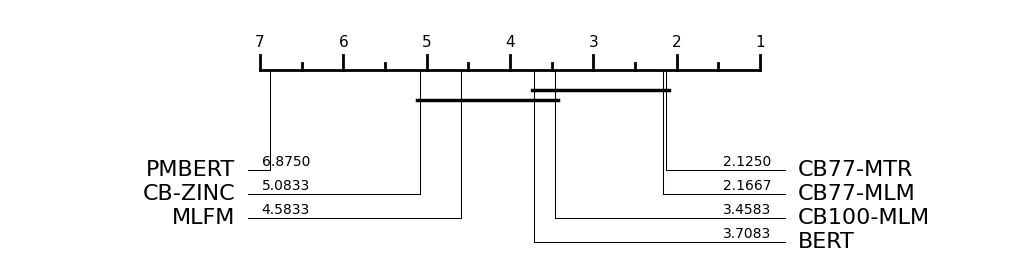

In [84]:
import matplotlib.pyplot as plt
from aeon.visualisation import plot_critical_difference

scores = embeding_estatistic.to_numpy()

# padronização mínima só onde faz diferença
name_map = {
    "PMBert": "PMBERT",
}

def extract_label(colname: str) -> str:
    # aceita tanto " – " quanto " | "
    if "–" in colname:
        base = colname.split("–", 1)[-1].strip()
    elif "|" in colname:
        base = colname.split("|", 1)[-1].strip()
    else:
        base = colname.strip()
    return name_map.get(base, base)

labels = [extract_label(col) for col in embeding_estatistic.columns]

plt.rcParams.update({
    "font.size": 14,
    "figure.figsize": (14, 5),
})

fig, ax = plot_critical_difference(
    scores=scores,
    labels=labels,
    alpha=0.1,
    lower_better=False,
    test="nemenyi",
    width=10,
    textspace=3.0,
)

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_9292\125778426.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


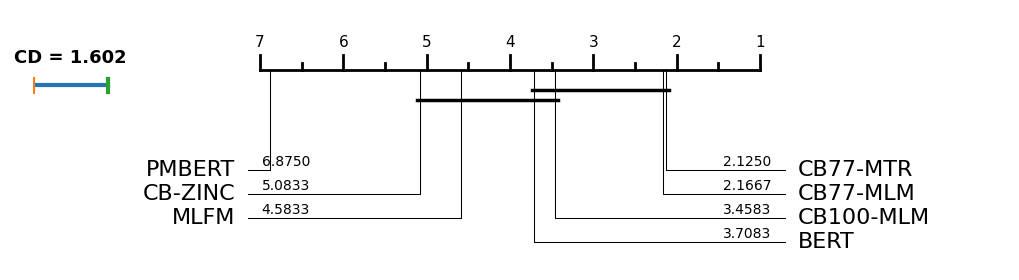

In [92]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from aeon.visualisation import plot_critical_difference
import numpy as np
import scikit_posthocs as sp
import math

scores = embeding_estatistic.to_numpy()

# padronização mínima só onde faz diferença
name_map = {
    "PMBert": "PMBERT",
}

def extract_label(colname: str) -> str:
    # aceita tanto " – " quanto " | "
    if "–" in colname:
        base = colname.split("–", 1)[-1].strip()
    elif "|" in colname:
        base = colname.split("|", 1)[-1].strip()
    else:
        base = colname.strip()
    return name_map.get(base, base)

labels = [extract_label(col) for col in embeding_estatistic.columns]

k = scores.shape[1]   # métodos
N = scores.shape[0]   # blocos

plt.rcParams.update({"font.size": 14, "figure.figsize": (14, 5)})

fig, ax = plot_critical_difference(
    scores=scores,
    labels=labels,
    alpha=0.1,
    lower_better=False,
    test="nemenyi",
    width=10,
    textspace=3.0,
)

# ===========================
# CD CORRETO PARA NEMENYI
# ===========================

q_alpha = 2.569 
CD = q_alpha * math.sqrt(k * (k + 1) / (6 * N))

# inset
ax_inset = inset_axes(ax, width="28%", height="28%", loc="upper left",
                      borderpad=1.2)

x0 = 1
x1 = 1 + CD
y = 0.5

ax_inset.plot([x0, x1], [y, y], linewidth=3)
ax_inset.plot([x0, x0], [y - 0.06, y + 0.06], linewidth=3)
ax_inset.plot([x1, x1], [y - 0.06, y + 0.06], linewidth=3)

ax_inset.text((x0 + x1) / 2, y + 0.18, f"CD = {CD:.3f}",
              ha="center", va="bottom", fontsize=13, weight="bold")

ax_inset.set_xlim(1, k)
ax_inset.set_ylim(0.3, 1.0)
ax_inset.axis("off")

plt.tight_layout()
plt.show()


## representações

In [119]:
import scipy.stats as stats
import scikit_posthocs as sp

# Friedman test
friedman_stat, friedman_p = stats.friedmanchisquare(
    *[representations_estatistica[col] for col in representations_estatistica.columns]
)

print("Friedman statistic:", friedman_stat)
print("p-value:", friedman_p)

# Post hoc Nemenyi CORRETO para Friedman
nemenyi = sp.posthoc_nemenyi_friedman(representations_estatistica)

nemenyi


Friedman statistic: 50.346774193548406
p-value: 3.056305910918393e-10


,DESC,DEST,EMBDESC,EMBDEST,Embedding
DESC,1.000000,7.905449e-04,0.997921,0.080112,8.011221e-02
DEST,0.000791,1.000000e+00,0.002702,0.636464,8.893344e-10
EMBDESC,0.997921,2.701797e-03,1.000000,0.166409,3.419861e-02
EMBDEST,0.080112,6.364643e-01,0.166409,1.000000,3.404183e-06
Embedding,0.080112,8.893344e-10,0.034199,0.000003,1.000000e+00


In [120]:
import pandas as pd

# Ranking por linha (quanto maior a métrica, melhor → rank 1 = melhor)
ranks = representations_estatistica.rank(axis=1, ascending=False)

# Ranking médio
mean_ranks = ranks.mean().round(4).sort_values()

mean_ranks

representacao
DEST         1.62
EMBDEST      2.24
EMBDESC      3.24
DESC         3.38
Embedding    4.52
dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_9292\3611184667.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


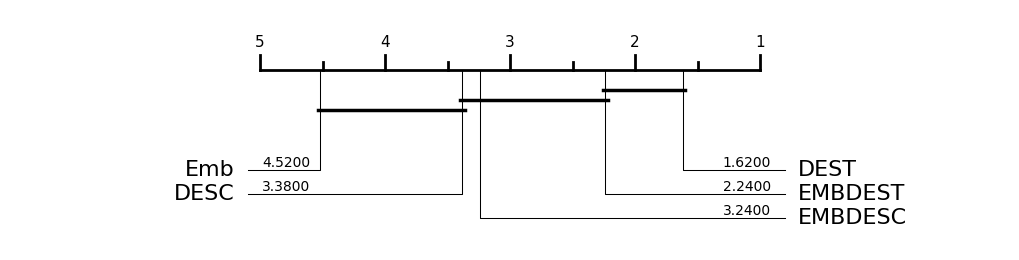

In [123]:
import matplotlib.pyplot as plt
from aeon.visualisation import plot_critical_difference

scores = representations_estatistica.to_numpy()

# padronização mínima só onde faz diferença
name_map = {
    "Embedding": "Emb",
}

def extract_label(colname: str) -> str:
    # aceita tanto " – " quanto " | "
    if "–" in colname:
        base = colname.split("–", 1)[-1].strip()
    elif "|" in colname:
        base = colname.split("|", 1)[-1].strip()
    else:
        base = colname.strip()
    return name_map.get(base, base)

labels = [extract_label(col) for col in representations_estatistica.columns]

plt.rcParams.update({
    "font.size": 14,
    "figure.figsize": (14, 5),
})

fig, ax = plot_critical_difference(
    scores=scores,
    labels=labels,
    alpha=0.1,
    lower_better=False,
    test="nemenyi",
    width=10,
    textspace=3.0,
)

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_9292\69380294.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


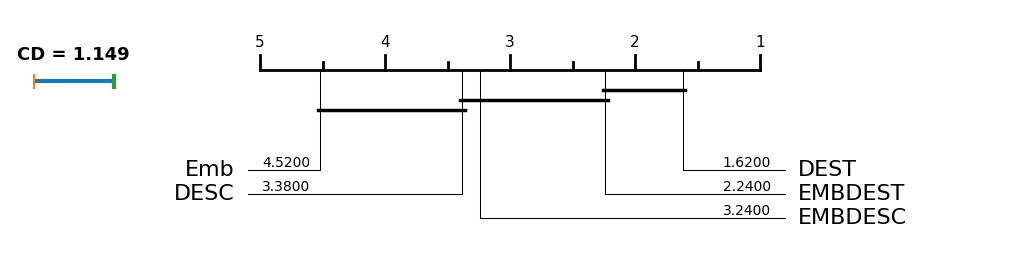

In [128]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from aeon.visualisation import plot_critical_difference
import numpy as np
import scikit_posthocs as sp
import math

scores = representations_estatistica.to_numpy()

# padronização mínima só onde faz diferença
name_map = {
    "Embedding": "Emb",
}

def extract_label(colname: str) -> str:
    # aceita tanto " – " quanto " | "
    if "–" in colname:
        base = colname.split("–", 1)[-1].strip()
    elif "|" in colname:
        base = colname.split("|", 1)[-1].strip()
    else:
        base = colname.strip()
    return name_map.get(base, base)

labels = [extract_label(col) for col in representations_estatistica.columns]

k = scores.shape[1]   # métodos
N = scores.shape[0]   # blocos

plt.rcParams.update({"font.size": 14, "figure.figsize": (14, 5)})

fig, ax = plot_critical_difference(
    scores=scores,
    labels=labels,
    alpha=0.1,
    lower_better=False,
    test="nemenyi",
    width=10,
    textspace=3.0,
)

# ===========================
# CD CORRETO PARA NEMENYI
# ===========================

q_alpha = 2.569 
CD = q_alpha * math.sqrt(k * (k + 1) / (6 * N))

# inset
ax_inset = inset_axes(ax, width="28%", height="28%", loc="upper left",
                      borderpad=1.2)

x0 = 1
x1 = 1 + CD
y = 0.5

ax_inset.plot([x0, x1], [y, y], linewidth=3)
ax_inset.plot([x0, x0], [y - 0.06, y + 0.06], linewidth=3)
ax_inset.plot([x1, x1], [y - 0.06, y + 0.06], linewidth=3)

ax_inset.text((x0 + x1) / 2, y + 0.18, f"CD = {CD:.3f}",
              ha="center", va="bottom", fontsize=13, weight="bold")

ax_inset.set_xlim(1, k)
ax_inset.set_ylim(0.3, 1.0)
ax_inset.axis("off")

plt.tight_layout()
plt.show()


# Classificações

In [135]:
import scipy.stats as stats
import scikit_posthocs as sp

# Friedman test
friedman_stat, friedman_p = stats.friedmanchisquare(
    *[model_estatistic[col] for col in model_estatistic.columns]
)

print("Friedman statistic:", friedman_stat)
print("p-value:", friedman_p)

# Post hoc Nemenyi CORRETO para Friedman
nemenyi = sp.posthoc_nemenyi_friedman(model_estatistic)

nemenyi


Friedman statistic: 34.609489051094904
p-value: 6.98107601560361e-05


,CatBoost,ExtraTrees,GradientBoosting,HistGradientBoosting,KNeighbors,LightGBM,MLPClassifier,NuSVC,RandomForest,XGBoost
CatBoost,1.000000,0.992761,0.063818,0.999907,0.167184,0.998033,0.995153,0.886843,0.610062,0.989497
ExtraTrees,0.992761,1.000000,0.535342,0.999994,0.782396,0.717554,1.000000,0.999959,0.992761,0.572784
GradientBoosting,0.063818,0.535342,1.000000,0.264569,0.999998,0.003571,0.498067,0.864285,0.985157,0.001520
HistGradientBoosting,0.999907,0.999994,0.264569,1.000000,0.498067,0.924536,0.999998,0.995153,0.924536,0.839286
KNeighbors,0.167184,0.782396,0.999998,0.498067,1.000000,0.014062,0.750853,0.972385,0.999319,0.006554
LightGBM,0.998033,0.717554,0.003571,0.924536,0.014062,1.000000,0.750853,0.356503,0.129563,1.000000
MLPClassifier,0.995153,1.000000,0.498067,0.999998,0.750853,0.750853,1.000000,0.999907,0.989497,0.610062
NuSVC,0.886843,0.999959,0.864285,0.995153,0.972385,0.356503,0.999907,1.000000,0.999983,0.237421
RandomForest,0.610062,0.992761,0.985157,0.924536,0.999319,0.129563,0.989497,0.999983,1.000000,0.074109
XGBoost,0.989497,0.572784,0.001520,0.839286,0.006554,1.000000,0.610062,0.237421,0.074109,1.000000


In [136]:
import pandas as pd

# Ranking por linha (quanto maior a métrica, melhor → rank 1 = melhor)
ranks = model_estatistic.rank(axis=1, ascending=False)

# Ranking médio
mean_ranks = ranks.mean().round(4).sort_values()

mean_ranks

Model
XGBoost                 1.6
LightGBM                2.0
CatBoost                3.6
HistGradientBoosting    4.7
MLPClassifier           5.4
ExtraTrees              5.5
NuSVC                   6.5
RandomForest            7.4
KNeighbors              8.8
GradientBoosting        9.5
dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_9292\2892265476.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


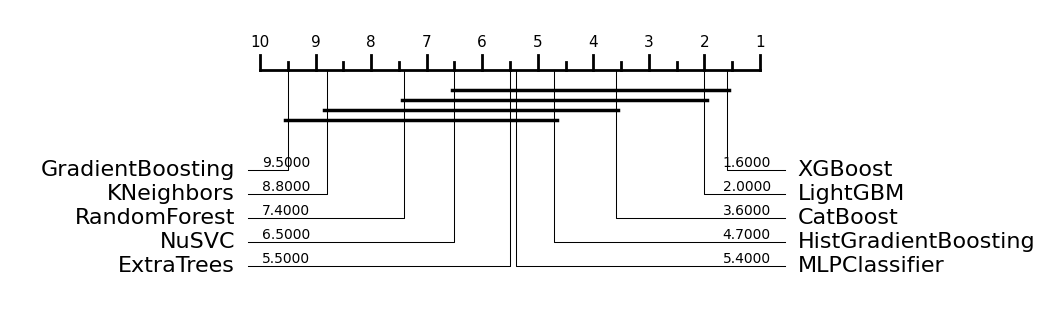

In [137]:
import matplotlib.pyplot as plt
from aeon.visualisation import plot_critical_difference

scores = model_estatistic.to_numpy()

# padronização mínima só onde faz diferença
name_map = {
    "Embedding": "Emb",
}

def extract_label(colname: str) -> str:
    # aceita tanto " – " quanto " | "
    if "–" in colname:
        base = colname.split("–", 1)[-1].strip()
    elif "|" in colname:
        base = colname.split("|", 1)[-1].strip()
    else:
        base = colname.strip()
    return name_map.get(base, base)

labels = [extract_label(col) for col in model_estatistic.columns]

plt.rcParams.update({
    "font.size": 14,
    "figure.figsize": (14, 5),
})

fig, ax = plot_critical_difference(
    scores=scores,
    labels=labels,
    alpha=0.1,
    lower_better=False,
    test="nemenyi",
    width=10,
    textspace=3.0,
)

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_9292\384907014.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


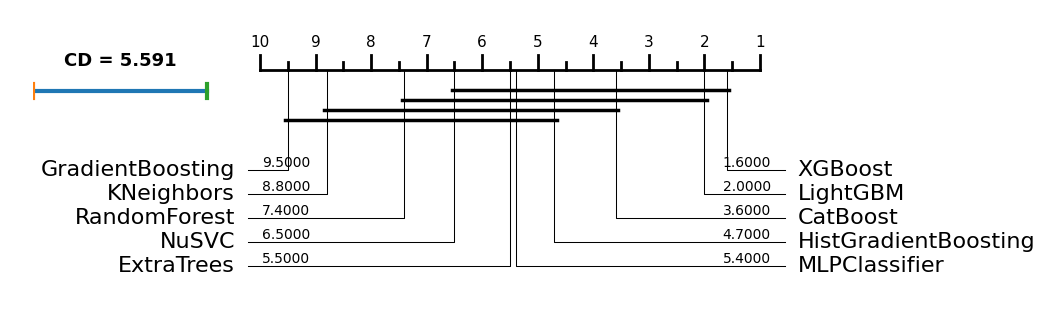

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from aeon.visualisation import plot_critical_difference
import numpy as np
import scikit_posthocs as sp
import math

scores = model_estatistic.to_numpy()

# padronização mínima só onde faz diferença
name_map = {
    "Embedding": "Emb",
}

def extract_label(colname: str) -> str:
    # aceita tanto " – " quanto " | "
    if "–" in colname:
        base = colname.split("–", 1)[-1].strip()
    elif "|" in colname:
        base = colname.split("|", 1)[-1].strip()
    else:
        base = colname.strip()
    return name_map.get(base, base)

labels = [extract_label(col) for col in model_estatistic.columns]

k = scores.shape[1]   # métodos
N = scores.shape[0]   # blocos

plt.rcParams.update({"font.size": 14, "figure.figsize": (14, 5)})

fig, ax = plot_critical_difference(
    scores=scores,
    labels=labels,
    alpha=0.1,
    lower_better=False,
    test="nemenyi",
    width=10,
    textspace=3.0,
)

# ===========================
# CD CORRETO PARA NEMENYI
# ===========================

q_alpha = 2.569 
CD = q_alpha * math.sqrt(k * (k + 1) / (6 * N))

# inset
ax_inset = inset_axes(ax, width="28%", height="28%", loc="upper left",
                      borderpad=1.2)

x0 = 1
x1 = 1 + CD
y = 0.5

ax_inset.plot([x0, x1], [y, y], linewidth=3)
ax_inset.plot([x0, x0], [y - 0.06, y + 0.06], linewidth=3)
ax_inset.plot([x1, x1], [y - 0.06, y + 0.06], linewidth=3)

ax_inset.text((x0 + x1) / 2, y + 0.18, f"CD = {CD:.3f}",
              ha="center", va="bottom", fontsize=13, weight="bold")

ax_inset.set_xlim(1, k)
ax_inset.set_ylim(0.3, 1.0)
ax_inset.axis("off")

plt.tight_layout()
plt.show()
